In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE
!pip install pyswarm --quiet

from pyswarm import pso  # Particle Swarm Optimization for feature selection

  Preparing metadata (setup.py) ... done


In [2]:
directory = "/content/risk_factors_cervical_cancer.csv"
df = pd.read_csv(directory)

In [3]:
print("Unique values in target variable (y):", df["Biopsy"].unique())
print("Class distribution:\n", df["Biopsy"].value_counts())


Unique values in target variable (y): [0 1]
Class distribution:
 Biopsy
0    803
1     55
Name: count, dtype: int64


In [4]:
# Replace '?' values with NaN
df.replace("?", np.nan, inplace=True)

# Identify missing values
print("Missing values before preprocessing:\n", df.isnull().sum())

# Drop rows with too many missing values (threshold: 30% missing)
df = df.dropna(thresh=int(0.3 * df.shape[1]))

Missing values before preprocessing:
 Age                                     0
Number of sexual partners              26
First sexual intercourse                7
Num of pregnancies                     56
Smokes                                 13
Smokes (years)                         13
Smokes (packs/year)                    13
Hormonal Contraceptives               108
Hormonal Contraceptives (years)       108
IUD                                   117
IUD (years)                           117
STDs                                  105
STDs (number)                         105
STDs:condylomatosis                   105
STDs:cervical condylomatosis          105
STDs:vaginal condylomatosis           105
STDs:vulvo-perineal condylomatosis    105
STDs:syphilis                         105
STDs:pelvic inflammatory disease      105
STDs:genital herpes                   105
STDs:molluscum contagiosum            105
STDs:AIDS                             105
STDs:HIV                              

In [5]:
# Impute missing values
num_imputer = SimpleImputer(strategy="mean")  # Mean for numerical features
cat_imputer = SimpleImputer(strategy="most_frequent")  # Mode for categorical features

num_cols = df.select_dtypes(include=["float64", "int64"]).columns
cat_cols = df.select_dtypes(include=["object"]).columns

df[num_cols] = num_imputer.fit_transform(df[num_cols])
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])


In [8]:
print(df.select_dtypes(include=['object']).columns)

Index(['Number of sexual partners', 'First sexual intercourse',
       'Num of pregnancies', 'Smokes', 'Smokes (years)', 'Smokes (packs/year)',
       'Hormonal Contraceptives', 'Hormonal Contraceptives (years)', 'IUD',
       'IUD (years)', 'STDs', 'STDs (number)', 'STDs:condylomatosis',
       'STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis',
       'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis',
       'STDs:pelvic inflammatory disease', 'STDs:genital herpes',
       'STDs:molluscum contagiosum', 'STDs:AIDS', 'STDs:HIV',
       'STDs:Hepatitis B', 'STDs:HPV', 'STDs: Time since first diagnosis',
       'STDs: Time since last diagnosis'],
      dtype='object')


In [9]:
df = df.apply(pd.to_numeric, errors='coerce')

In [10]:

# Standardize numerical features
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# Ensure target variable is categorical (0 or 1)
df["Biopsy"] = df["Biopsy"].apply(lambda x: 1 if x > 0 else 0)  # Convert all nonzero values to 1


# Define features and target
X = df.drop(columns=["Biopsy"])
y = df["Biopsy"]

# Apply SMOTE for class balancing
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split dataset into training & testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42,stratify=y_resampled
)

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])

Training samples: 963
Testing samples: 241


In [11]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, matthews_corrcoef,
    mean_squared_error
)

# Define models
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "SVC": SVC(kernel='rbf', probability=True, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=5, random_state=42),
    "Gaussian NB": GaussianNB(var_smoothing=1e-5),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "AdaBoost": AdaBoostClassifier(random_state=42)
}

# Results storage
performance_results = []
mse_rmse_results = []
cv_results = []

# 10-Fold CV setup
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Model evaluation loop
for name, model in models.items():
    print(f"\nTraining {name} (Without PSO)...")

    # 10-fold cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')

    # Train model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else y_pred

    # Calculate MSE and RMSE
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    # Performance metrics
    performance_results.append({
        "Model": name,
        "Test Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "AUC": roc_auc_score(y_test, y_proba),
        "MCC": matthews_corrcoef(y_test, y_pred)
    })

    # MSE & RMSE
    mse_rmse_results.append({
        "Model": name,
        "MSE": mse,
        "RMSE": rmse
    })

    # CV Accuracy
    cv_results.append({
        "Model": name,
        "10-Fold CV Accuracy": np.mean(cv_scores)
    })

# Convert to DataFrames
performance_df = pd.DataFrame(performance_results).sort_values(by="Test Accuracy", ascending=False)
mse_rmse_df = pd.DataFrame(mse_rmse_results).sort_values(by="MSE")
cv_df = pd.DataFrame(cv_results).sort_values(by="10-Fold CV Accuracy", ascending=False)

# Display outputs
print()
print("Performance of All Models (Without PSO)")
print()
print(performance_df.to_string(index=False))

print()
print("Mean Squared Error (MSE) and Root MSE (RMSE) (Without PSO)")
print()
print(mse_rmse_df.to_string(index=False))

print()
print("10-Fold Cross-Validation Accuracy (Without PSO)")
print()
print(cv_df.to_string(index=False))



Training Logistic Regression (Without PSO)...

Training SVC (Without PSO)...

Training Random Forest (Without PSO)...

Training Gaussian NB (Without PSO)...

Training Decision Tree (Without PSO)...

Training XGBoost (Without PSO)...

Training KNN (Without PSO)...

Training AdaBoost (Without PSO)...

Performance of All Models (Without PSO)

              Model  Test Accuracy  Precision  Recall  F1 Score      AUC      MCC
      Random Forest       0.970954   0.950617  0.9625  0.956522 0.993672 0.934757
            XGBoost       0.966805   0.961538  0.9375  0.949367 0.995807 0.924846
           AdaBoost       0.966805   0.961538  0.9375  0.949367 0.988432 0.924846
      Decision Tree       0.958506   0.948718  0.9250  0.936709 0.950078 0.906013
                KNN       0.954357   0.896552  0.9750  0.934132 0.988665 0.901157
Logistic Regression       0.946058   0.946667  0.8875  0.916129 0.978649 0.877426
                SVC       0.937759   0.933333  0.8750  0.903226 0.979425 0.858395
 


Logistic Regression — Confusion Matrix


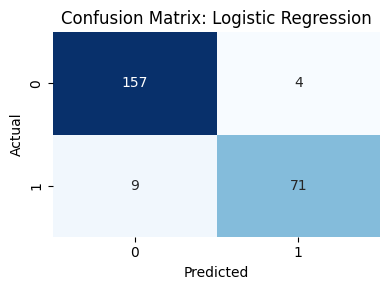


SVC — Confusion Matrix


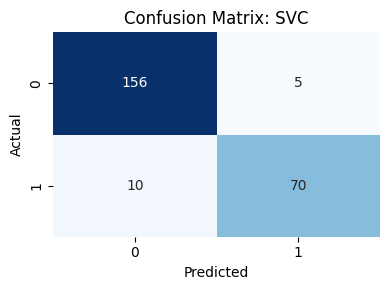


Random Forest — Confusion Matrix


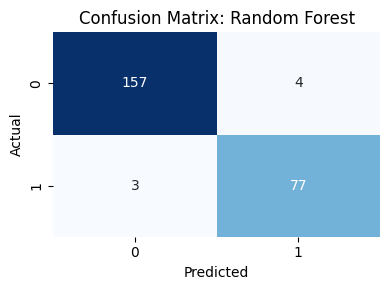


Gaussian NB — Confusion Matrix


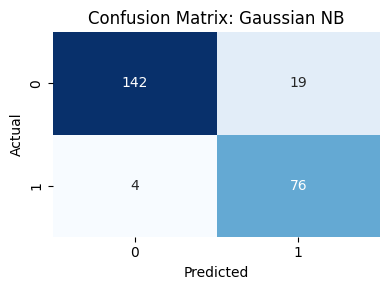


Decision Tree — Confusion Matrix


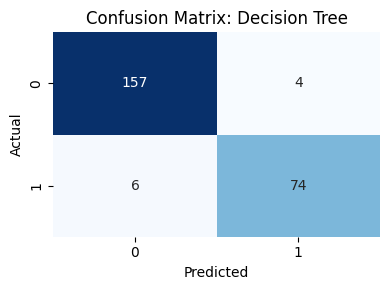


XGBoost — Confusion Matrix


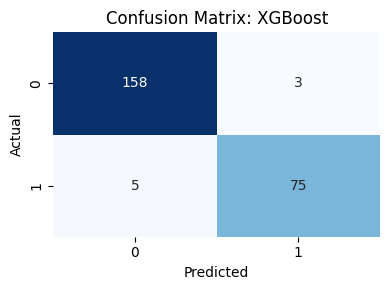


KNN — Confusion Matrix


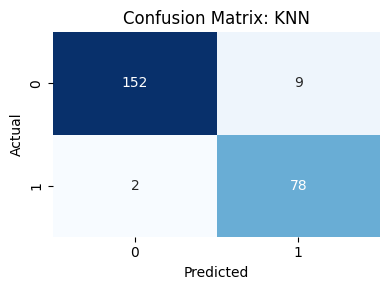


AdaBoost — Confusion Matrix


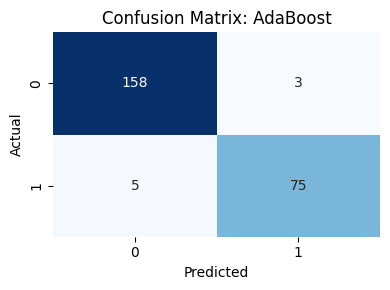

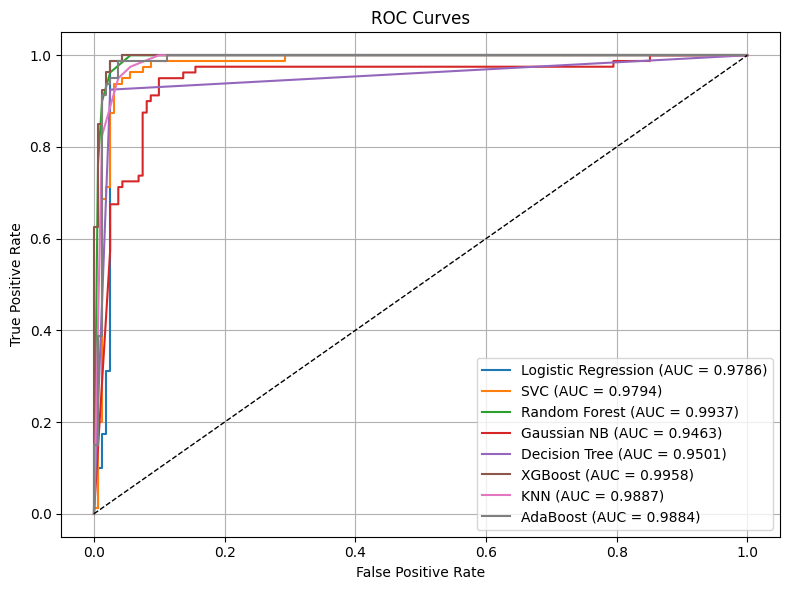

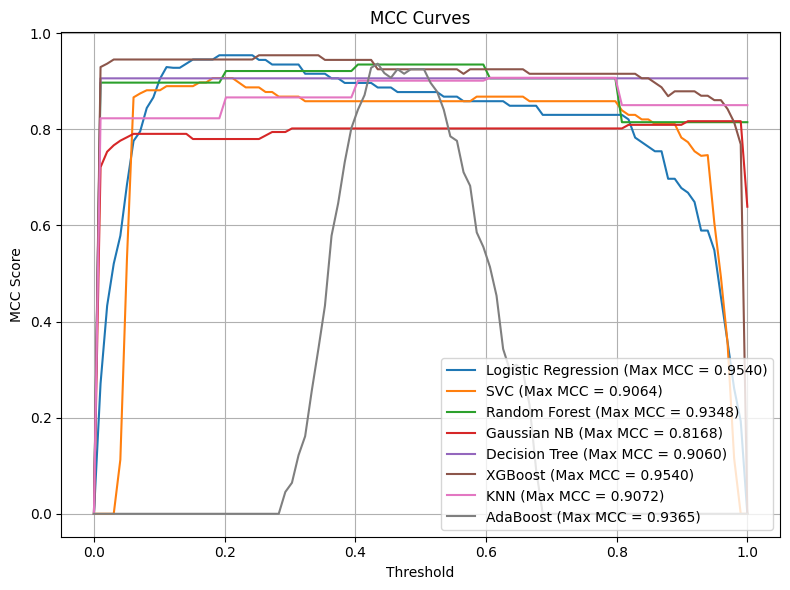

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc, matthews_corrcoef

# Confusion Matrix Visualization
def plot_confusion_matrix(model, X_test, y_test, title):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix: {title}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

# ROC Curve Visualization
def plot_roc_curve(models, X_tests, y_test):
    plt.figure(figsize=(8, 6))
    for name, model in models.items():
        X_test_sel = X_tests[name]
        if hasattr(model, "predict_proba"):
            y_scores = model.predict_proba(X_test_sel)[:, 1]
        else:
            y_scores = model.decision_function(X_test_sel)

        fpr, tpr, _ = roc_curve(y_test, y_scores)
        auc_score = auc(fpr, tpr)

        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.4f})")

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.grid(True)
    plt.show()

# MCC Curve Visualization
def plot_mcc_curve(models, X_tests, y_test):
    plt.figure(figsize=(8, 6))
    for name, model in models.items():
        X_test_sel = X_tests[name]
        if hasattr(model, "predict_proba"):
            y_scores = model.predict_proba(X_test_sel)[:, 1]
        else:
            y_scores = model.decision_function(X_test_sel)

        thresholds = np.linspace(0, 1, 100)
        mcc_scores = []

        for thresh in thresholds:
            y_pred = (y_scores >= thresh).astype(int)
            mcc = matthews_corrcoef(y_test, y_pred)
            mcc_scores.append(mcc)

        max_mcc = max(mcc_scores)
        plt.plot(
            thresholds,
            mcc_scores,
            label=f"{name} (Max MCC = {max_mcc:.4f})"
        )

    plt.xlabel("Threshold")
    plt.ylabel("MCC Score")
    plt.title("MCC Curves")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.grid(True)
    plt.show()

# ---------- Run Visualizations ----------

# Create selected feature sets for each model (assuming you've got the model fitted and X_test selected)
X_test_selected_dict = {}
for name, model in models.items():
    # Assuming you have your X_test already available
    X_test_selected_dict[name] = X_test  # or use the selected features from your PSO

    # Plot Confusion Matrix
    print(f"\n{name} — Confusion Matrix")
    plot_confusion_matrix(model, X_test_selected_dict[name], y_test, name)

# Plot ROC Curve for all models
plot_roc_curve(models, X_test_selected_dict, y_test)

# Plot MCC Curve for all models
plot_mcc_curve(models, X_test_selected_dict, y_test)


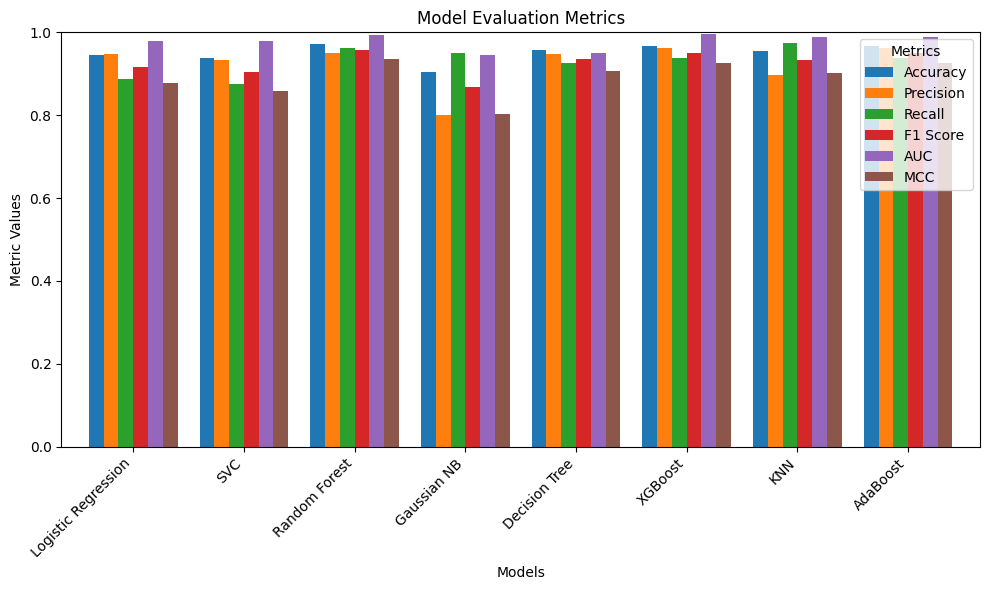

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef

#  Collect results for each model
metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "AUC", "MCC"]
model_names = list(models.keys())
model_results = {metric: [] for metric in metrics}

# Evaluate each model and collect metrics
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = model.decision_function(X_test)

    # Collect metrics
    model_results["Accuracy"].append(accuracy_score(y_test, y_pred))
    model_results["Precision"].append(precision_score(y_test, y_pred))
    model_results["Recall"].append(recall_score(y_test, y_pred))
    model_results["F1 Score"].append(f1_score(y_test, y_pred))
    model_results["AUC"].append(roc_auc_score(y_test, y_proba))
    model_results["MCC"].append(matthews_corrcoef(y_test, y_pred))

# Convert results into DataFrame for better handling
df_results = pd.DataFrame(model_results, index=model_names)

# Plotting the comparison bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for each metric
df_results.plot(kind='bar', ax=ax, width=0.8)

# Customize plot
ax.set_title("Model Evaluation Metrics")
ax.set_ylabel("Metric Values")
ax.set_xlabel("Models")
ax.set_ylim(0, 1)  # Set y-axis limit to [0, 1] for all metrics except MCC
ax.legend(title="Metrics", loc="upper right")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# Show the plot
plt.show()

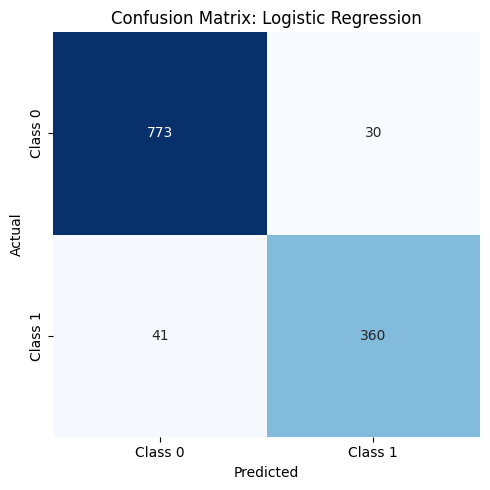

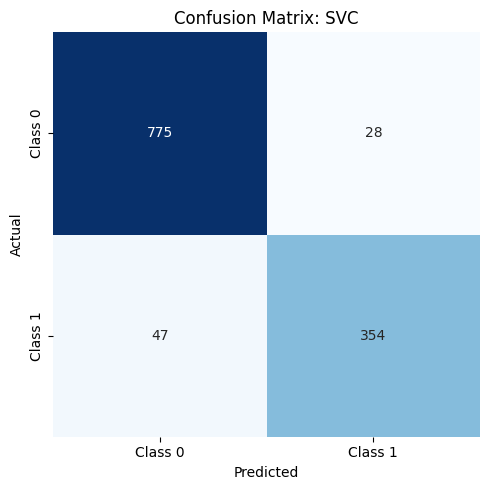

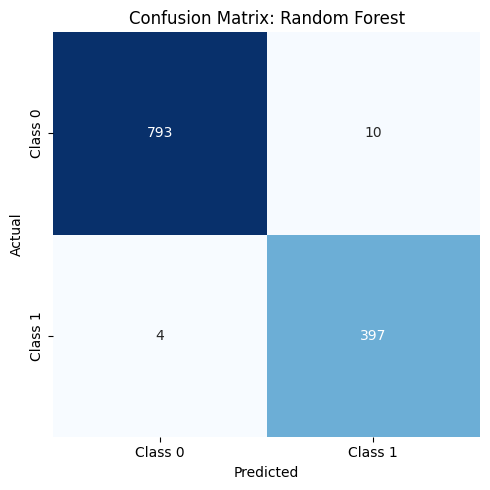

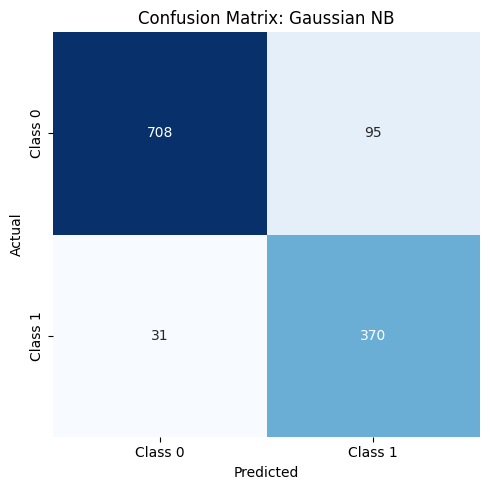

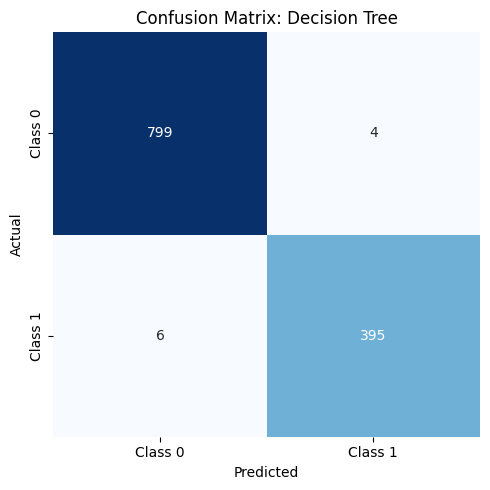

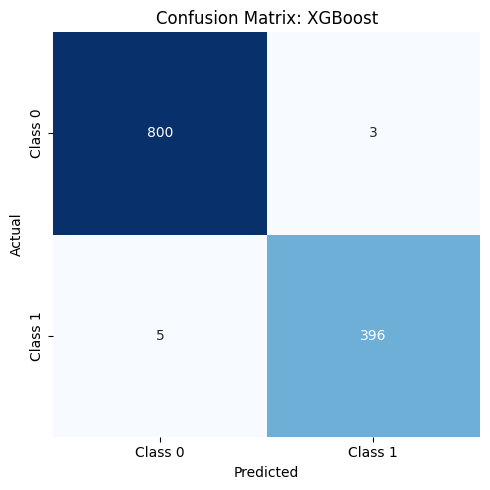

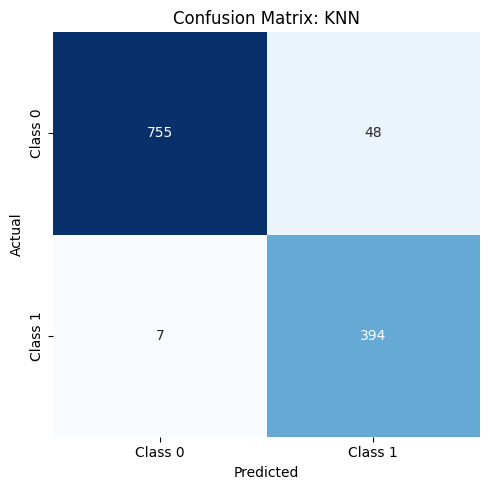

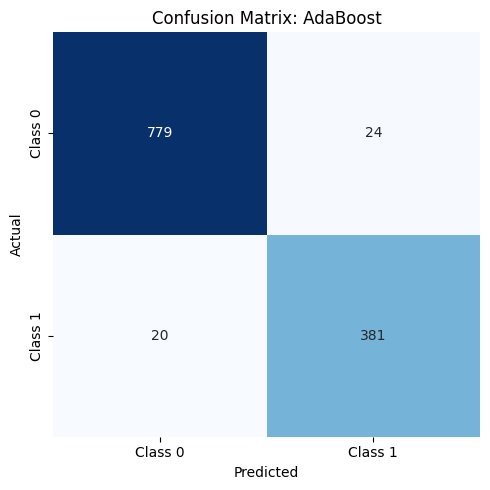

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming X_train, y_train, X_test, y_test are defined and ready

# Loop through models and plot confusion matrix for each
for name, model in models.items():
    model.fit(X_train, y_train)  # Train on the training data

    # Predict on the full dataset (combining train and test)
    y_full_pred = model.predict(pd.concat([X_train, X_test], axis=0))
    y_full_true = pd.concat([y_train, y_test], axis=0)

    # Generate confusion matrix
    cm = confusion_matrix(y_full_true, y_full_pred)

    # Plot confusion matrix
    plt.figure(figsize=(5, 5))  # Size reduced
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

In [19]:
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, matthews_corrcoef,
    mean_squared_error
)
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# PSO Parameters
NUM_PARTICLES = 30
NUM_ITERATIONS = 100
INERTIA_WEIGHT = 0.8
ACC1 = 2
ACC2 = 2
ALPHA = 0.95
MIN_FEATURES = 1
MAX_FEATURES = 8

# PSO Initialization
def initialize_particles(n_particles, dim):
    particles = np.zeros((n_particles, dim), dtype=int)
    for i in range(n_particles):
        num_feats = np.random.randint(MIN_FEATURES, MAX_FEATURES + 1)
        indices = np.random.choice(dim, num_feats, replace=False)
        particles[i, indices] = 1
    return particles

# Fitness Function
def fitness(position, model, X_train, y_train, X_val, y_val, alpha=ALPHA):
    selected_idx = np.where(position == 1)[0]
    if len(selected_idx) == 0:
        return 0
    X_train_sel = X_train.iloc[:, selected_idx]
    X_val_sel = X_val.iloc[:, selected_idx]

    try:
        model.fit(X_train_sel, y_train)
        y_pred = model.predict(X_val_sel)
        acc = accuracy_score(y_val, y_pred)
        penalty = len(selected_idx) / X_train.shape[1]
        return acc - (1 - alpha) * penalty
    except:
        return 0

# PSO Feature Selection Function
def pso_select(X_train, y_train, model):
    dim = X_train.shape[1]
    particles = initialize_particles(NUM_PARTICLES, dim)
    velocities = np.random.uniform(-1, 1, (NUM_PARTICLES, dim))

    X_subtrain, X_val, y_subtrain, y_val = train_test_split(
        X_train, y_train, test_size=0.2, stratify=y_train, random_state=SEED
    )

    personal_best = particles.copy()
    personal_best_scores = np.array([
        fitness(p, model, X_subtrain, y_subtrain, X_val, y_val) for p in particles
    ])
    global_best = personal_best[np.argmax(personal_best_scores)]

    for _ in range(NUM_ITERATIONS):
        for i in range(NUM_PARTICLES):
            r1, r2 = np.random.rand(dim), np.random.rand(dim)
            velocities[i] = (
                INERTIA_WEIGHT * velocities[i] +
                ACC1 * r1 * (personal_best[i] - particles[i]) +
                ACC2 * r2 * (global_best - particles[i])
            )
            sigmoid = 1 / (1 + np.exp(-velocities[i]))
            new_position = np.where(np.random.rand(dim) < sigmoid, 1, 0)

            if np.sum(new_position) == 0:
                new_position[random.randint(0, dim - 1)] = 1

            if np.sum(new_position) > MAX_FEATURES:
                indices = np.where(new_position == 1)[0]
                new_position[indices[MAX_FEATURES:]] = 0

            score = fitness(new_position, model, X_subtrain, y_subtrain, X_val, y_val)
            if score > personal_best_scores[i]:
                personal_best[i] = new_position
                personal_best_scores[i] = score

        global_best = personal_best[np.argmax(personal_best_scores)]

    return np.where(global_best == 1)[0]

# Define models
models = {
    "Logistic Regression": LogisticRegression(random_state=SEED, max_iter=1000),
    "SVC": SVC(kernel='rbf', probability=True, random_state=SEED),
    "Random Forest": RandomForestClassifier(random_state=SEED),
    "Gaussian NB": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=SEED),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=SEED),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "AdaBoost": AdaBoostClassifier(random_state=SEED)
}

# Your input data must be defined here
# Example:
# X_resampled = pd.DataFrame(...)  # your features DataFrame
# y_resampled = pd.Series(...)     # your target Series

# Save feature names
feature_names = X_resampled.columns.tolist()

# Final Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=SEED
)

# Run PSO and evaluate
test_results = []
mse_rmse_results = []
cv_results = []
feature_name_results = []

for name, model in models.items():
    print(f"\nRunning PSO for {name}")
    selected_idx = pso_select(X_train, y_train, model)
    selected_features = [feature_names[i] for i in selected_idx]

    X_train_sel = X_train.iloc[:, selected_idx]
    X_test_sel = X_test.iloc[:, selected_idx]

    model.fit(X_train_sel, y_train)
    y_pred = model.predict(X_test_sel)
    y_proba = model.predict_proba(X_test_sel)[:, 1] if hasattr(model, "predict_proba") else y_pred

    test_results.append({
        "Model": name,
        "Test Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "AUC": roc_auc_score(y_test, y_proba),
        "MCC": matthews_corrcoef(y_test, y_pred),
        "Selected Features": selected_idx.tolist()
    })

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mse_rmse_results.append({
        "Model": name,
        "MSE": mse,
        "RMSE": rmse
    })

    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)
    cv_score = cross_val_score(model, X_train_sel, y_train, cv=cv, scoring='accuracy')
    cv_results.append({
        "Model": name,
        "10-Fold CV Accuracy": np.mean(cv_score)
    })

    feature_name_results.append({
        "Model": name,
        "Selected Feature Names": selected_features
    })

# Convert to DataFrames
test_df = pd.DataFrame(test_results).sort_values(by="Test Accuracy", ascending=False)
mse_rmse_df = pd.DataFrame(mse_rmse_results).sort_values(by="RMSE")
cv_df = pd.DataFrame(cv_results).sort_values(by="10-Fold CV Accuracy", ascending=False)
feature_df = pd.DataFrame(feature_name_results)

# Display Results

print("\nSelected Features for each model by PSO")
for row in feature_name_results:
    print(f"{row['Model']}: {row['Selected Feature Names']}")

print("\nPerformance of All Models (With PSO)")
print(test_df.to_string(index=False))

print("\nMSE & RMSE of All Models (With PSO)")
print(mse_rmse_df.to_string(index=False))

print("\n10-Fold Cross-Validation Accuracy (With PSO)")
print(cv_df.to_string(index=False))




Running PSO for Logistic Regression

Running PSO for SVC

Running PSO for Random Forest

Running PSO for Gaussian NB

Running PSO for Decision Tree

Running PSO for XGBoost

Running PSO for KNN

Running PSO for AdaBoost

Selected Features for each model by PSO
Logistic Regression: ['First sexual intercourse', 'Hormonal Contraceptives (years)', 'STDs: Number of diagnosis', 'Dx:Cancer', 'Schiller']
SVC: ['Smokes (packs/year)', 'STDs:vaginal condylomatosis', 'STDs:Hepatitis B', 'Schiller']
Random Forest: ['STDs:condylomatosis', 'STDs:vaginal condylomatosis', 'Dx:Cancer', 'Schiller']
Gaussian NB: ['STDs:condylomatosis', 'Dx', 'Schiller', 'Citology']
Decision Tree: ['Smokes', 'Dx:Cancer', 'Dx', 'Schiller']
XGBoost: ['Age', 'Number of sexual partners', 'STDs:vaginal condylomatosis', 'STDs: Time since first diagnosis', 'Dx:CIN', 'Schiller']
KNN: ['Smokes', 'STDs:HIV', 'STDs:HPV', 'Schiller']
AdaBoost: ['Smokes', 'Dx:CIN', 'Schiller']

Performance of All Models (With PSO)
              Model 

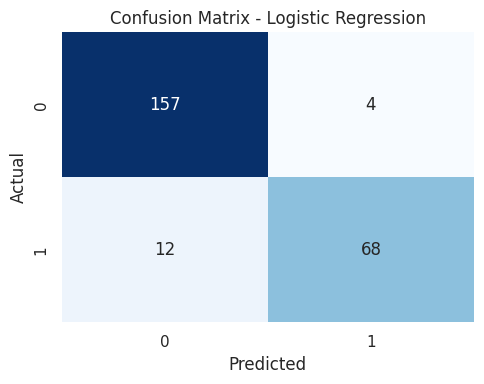

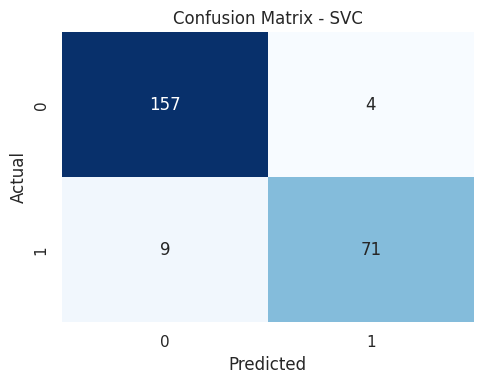

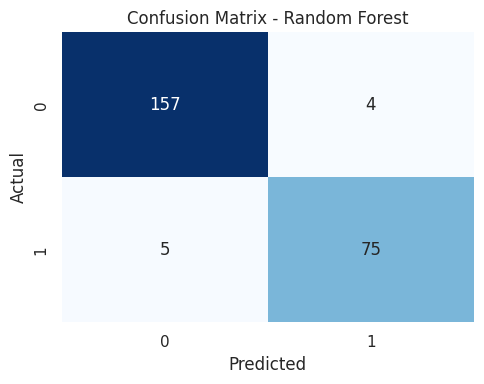

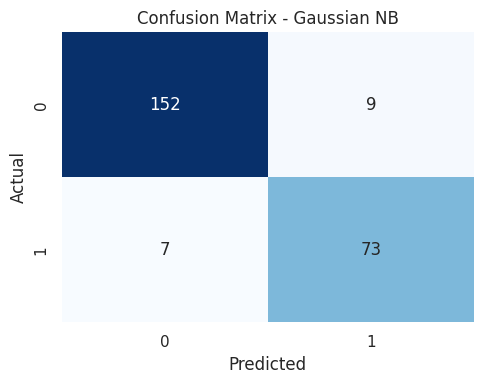

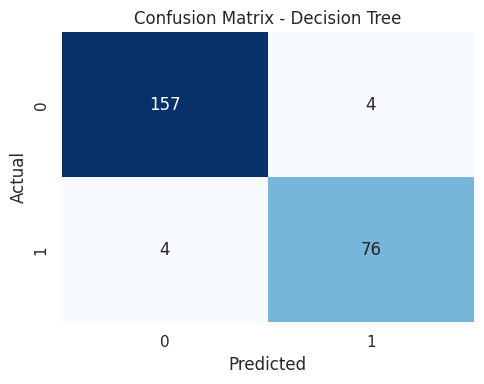

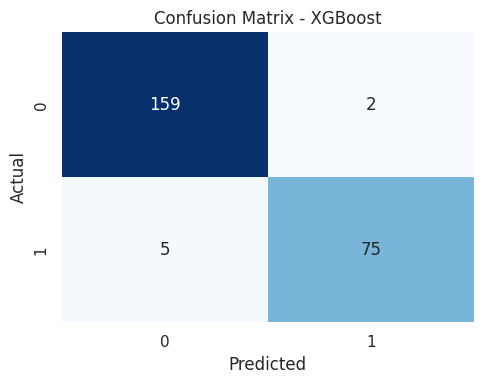

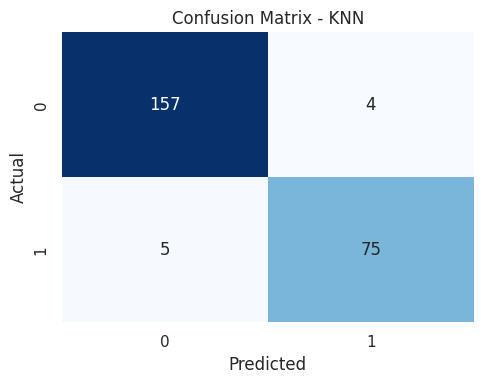

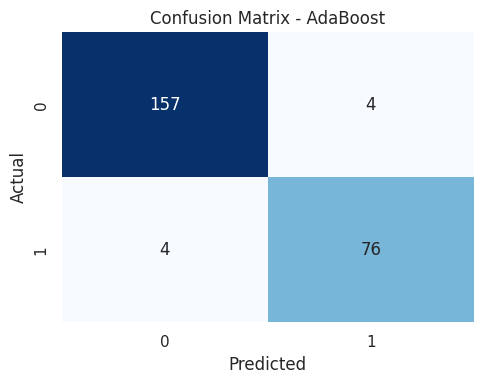

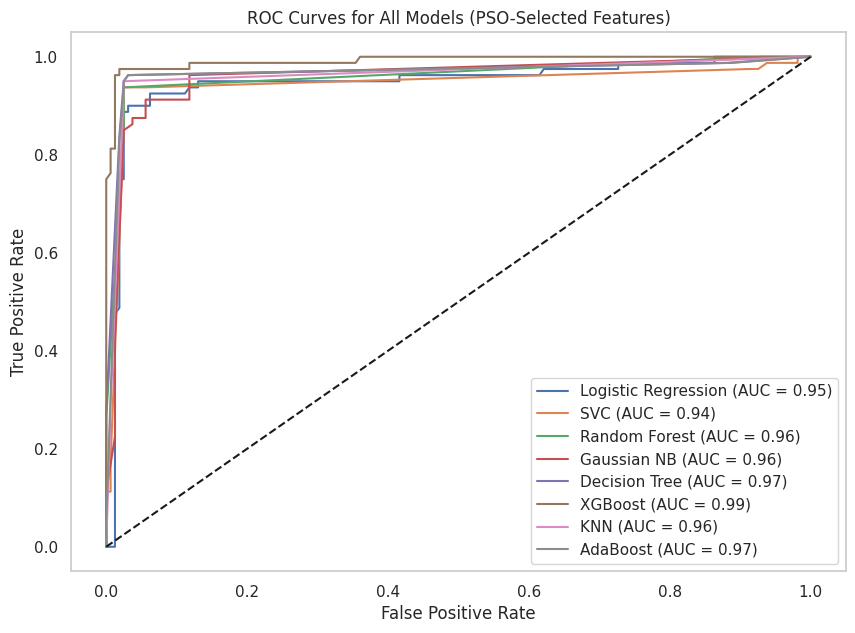

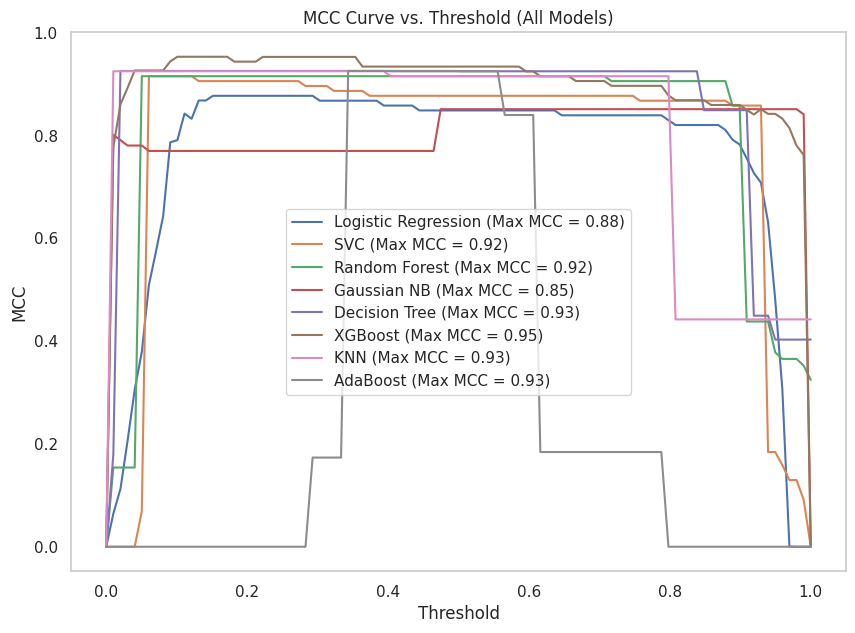

In [29]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, matthews_corrcoef
from sklearn.base import clone
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Store predictions and probabilities for visualization
model_predictions = {}
model_probabilities = {}

for result in test_results:
    name = result["Model"]
    selected_idx = result["Selected Features"]
    selected_features = [feature_names[i] for i in selected_idx]

    # Clone the model to avoid sklearn feature mismatch error
    fresh_model = clone(models[name])
    X_train_sel = X_train[selected_features]
    X_test_sel = X_test[selected_features]

    # Retrain on selected features to avoid fit/predict mismatch
    fresh_model.fit(X_train_sel, y_train)
    y_pred = fresh_model.predict(X_test_sel)
    y_proba = fresh_model.predict_proba(X_test_sel)[:, 1] if hasattr(fresh_model, "predict_proba") else y_pred

    model_predictions[name] = y_pred
    model_probabilities[name] = y_proba

# Confusion Matrices (one at a time)
for name, y_pred in model_predictions.items():
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

# ROC Curve (Combined)
plt.figure(figsize=(10, 7))
for name, y_proba in model_probabilities.items():
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for All Models (PSO-Selected Features)")
plt.legend()
plt.grid()
plt.show()

# MCC Curve (Combined)
plt.figure(figsize=(10, 7))
for name, y_proba in model_probabilities.items():
    thresholds = np.linspace(0, 1, 100)
    mccs = []
    for thresh in thresholds:
        preds = (y_proba >= thresh).astype(int)
        mcc = matthews_corrcoef(y_test, preds)
        mccs.append(mcc)
    plt.plot(thresholds, mccs, label=f"{name} (Max MCC = {np.max(mccs):.2f})")
plt.xlabel("Threshold")
plt.ylabel("MCC")
plt.title("MCC Curve vs. Threshold (All Models)")
plt.legend()
plt.grid()
plt.show()


<Figure size 1200x800 with 0 Axes>

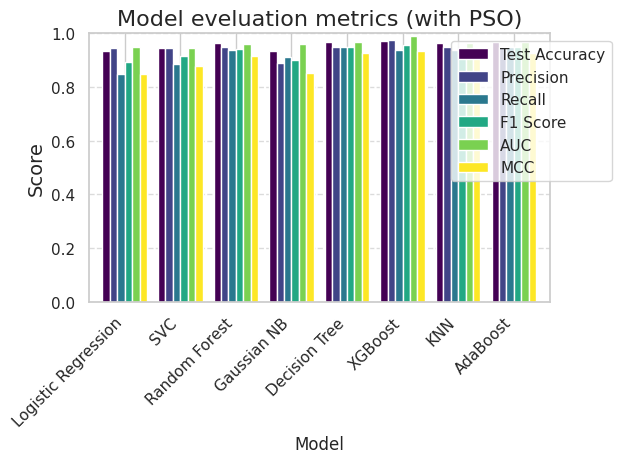

In [38]:
import matplotlib.pyplot as plt
import pandas as pd

# Build a DataFrame of your main performance metrics
perf_df = (
    pd.DataFrame(test_results)
      .set_index("Model")[["Test Accuracy", "Precision", "Recall", "F1 Score", "AUC", "MCC"]]
)

# Plot all metrics in one grouped bar chart
plt.figure(figsize=(12, 8))
perf_df.plot(kind="bar", colormap="viridis", width=0.8)

plt.title("Model eveluation metrics (with PSO)", fontsize=16)
plt.ylabel("Score", fontsize=14)
plt.ylim(0, 1.0)
plt.xticks(rotation=45, ha="right")
plt.legend(loc="upper right", bbox_to_anchor=(1.15, 1))
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


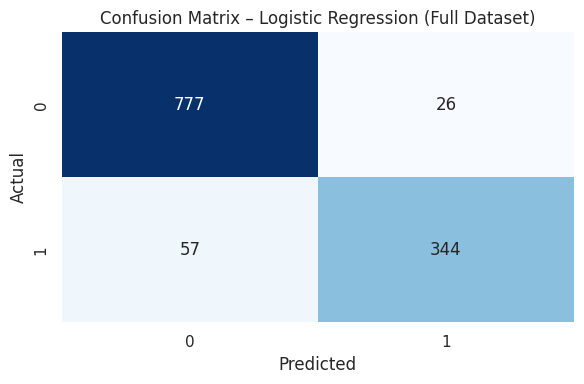

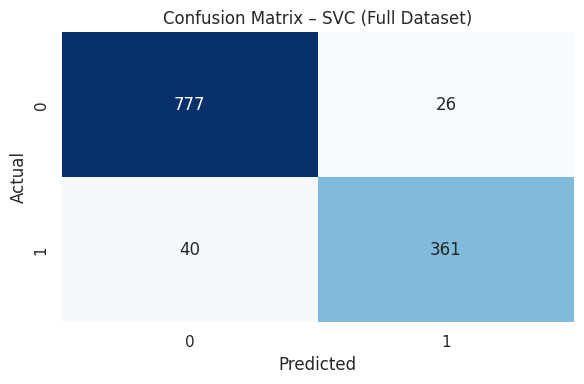

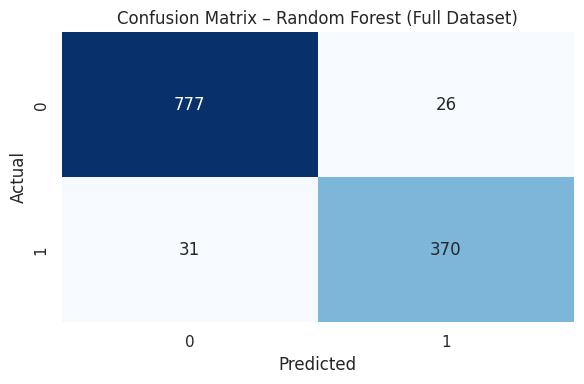

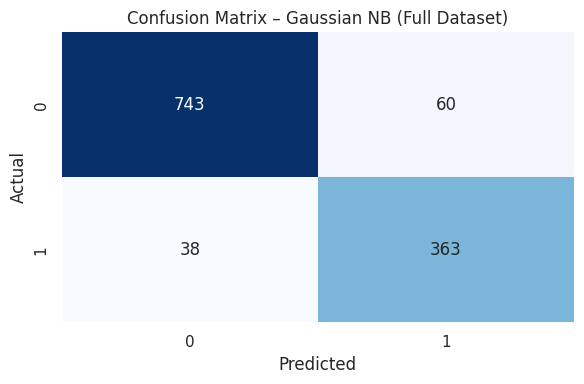

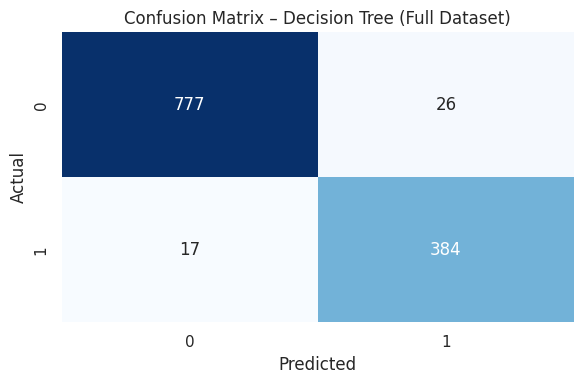

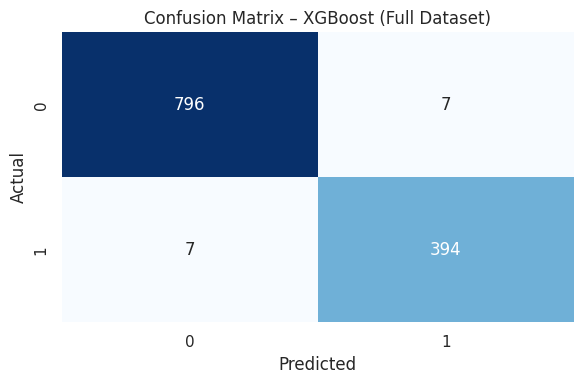

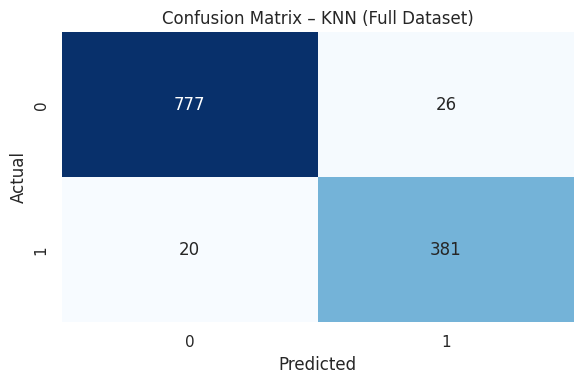

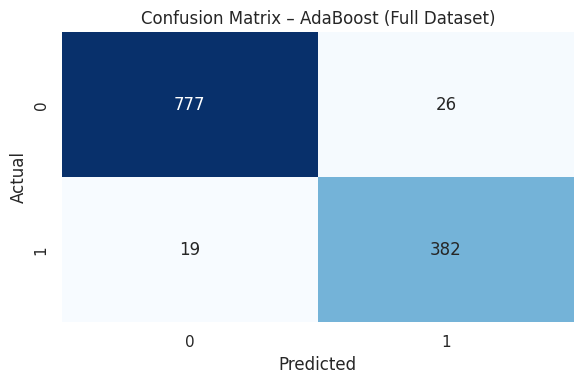

In [52]:
from sklearn.metrics import confusion_matrix
from sklearn.base import clone
import matplotlib.pyplot as plt
import seaborn as sns

# Plot each model’s confusion matrix on the entire dataset (X_resampled, y_resampled)
for result in test_results:
    name = result["Model"]
    sel_idx = result["Selected Features"]
    sel_feats = [feature_names[i] for i in sel_idx]

    # Clone and train on the full resampled dataset
    fresh_model = clone(models[name])
    fresh_model.fit(X_resampled[sel_feats], y_resampled)

    # Predict on the entire resampled dataset
    y_pred_all = fresh_model.predict(X_resampled[sel_feats])

    # Compute confusion matrix
    cm = confusion_matrix(y_resampled, y_pred_all)

    # Plot it
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix – {name} (Full Dataset)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()


In [44]:
from sklearn.metrics import accuracy_score
from sklearn.base import clone

# Choose a test row (must be within range of X_test)
row_index = 65
true_label = y_test.iloc[row_index]

print(f"\nTrue Diagnosis: {'Positive' if true_label == 1 else 'Negative'}")
print("Patient Data (Full):")
print(X_test.iloc[row_index].to_dict())

print("\nPredictions from All Models (PSO‑Selected Features):\n")

for result in test_results:
    name = result["Model"]
    selected_idx = result["Selected Features"]
    # Map indices back to column names
    selected_features = [feature_names[i] for i in selected_idx]

    # Clone and retrain on PSO‑selected features to avoid any feature‑name mismatch
    fresh_model = clone(models[name])
    X_train_sel = X_train[selected_features]
    X_test_sel = X_test[selected_features]
    fresh_model.fit(X_train_sel, y_train)

    # Prepare the single‐row input
    test_input = X_test_sel.iloc[[row_index]]

    # Make prediction
    pred = fresh_model.predict(test_input)[0]
    label = "Positive" if pred == 1 else "Negative"
    correctness = "correct" if pred == true_label else "wrong"

    print(f" {name}: {label} ({correctness})")



True Diagnosis: Positive
Patient Data (Full):
{'Age': 0.6064562264535601, 'Number of sexual partners': 1.783653012741143, 'First sexual intercourse': 17.0, 'Num of pregnancies': 2.783653012741143, 'Smokes': 0.0, 'Smokes (years)': 0.0, 'Smokes (packs/year)': 0.0, 'Hormonal Contraceptives': 1.0, 'Hormonal Contraceptives (years)': 1.4326939745177139, 'IUD': 0.0, 'IUD (years)': 0.0, 'STDs': 0.0, 'STDs (number)': 0.0, 'STDs:condylomatosis': 0.0, 'STDs:cervical condylomatosis': 0.0, 'STDs:vaginal condylomatosis': 0.0, 'STDs:vulvo-perineal condylomatosis': 0.0, 'STDs:syphilis': 0.0, 'STDs:pelvic inflammatory disease': 0.0, 'STDs:genital herpes': 0.0, 'STDs:molluscum contagiosum': 0.0, 'STDs:AIDS': 0.0, 'STDs:HIV': 0.0, 'STDs:Hepatitis B': 0.0, 'STDs:HPV': 0.0, 'STDs: Number of diagnosis': -0.28909301541595755, 'STDs: Time since first diagnosis': 1.0, 'STDs: Time since last diagnosis': 1.0, 'Dx:Cancer': -0.14638501094227996, 'Dx:CIN': -0.10295973345818707, 'Dx:HPV': -0.14638501094227996, 'Dx'

In [45]:
from sklearn.metrics import accuracy_score
from sklearn.base import clone

# Choose a test row
row_index = 1  # change as needed
true_label = y_test.iloc[row_index]

print(f"\nTrue Diagnosis: {'Positive' if true_label == 1 else 'Negative'}")
print("Patient Data (Full):")
print(X_test.iloc[row_index].to_dict())

print("\nPredictions from All Models (PSO‑Selected Features):\n")

for result in test_results:
    name = result["Model"]
    selected_idx = result["Selected Features"]
    # Map indices to feature names
    selected_features = [feature_names[i] for i in selected_idx]

    # Clone and retrain the model on PSO‑selected features
    fresh_model = clone(models[name])
    fresh_model.fit(X_train[selected_features], y_train)

    # Prepare single‐row input
    test_input = X_test[selected_features].iloc[[row_index]]

    # Predict
    pred = fresh_model.predict(test_input)[0]
    label = "Positive" if pred == 1 else "Negative"
    correctness = "correct" if pred == true_label else "wrong"

    print(f" {name}: {label} ({correctness})")



True Diagnosis: Negative
Patient Data (Full):
{'Age': 2.25827148723661, 'Number of sexual partners': 3.0, 'First sexual intercourse': 21.0, 'Num of pregnancies': 4.0, 'Smokes': 0.0, 'Smokes (years)': 0.0, 'Smokes (packs/year)': 0.0, 'Hormonal Contraceptives': 1.0, 'Hormonal Contraceptives (years)': 15.0, 'IUD': 0.0, 'IUD (years)': 0.0, 'STDs': 0.0, 'STDs (number)': 0.0, 'STDs:condylomatosis': 0.0, 'STDs:cervical condylomatosis': 0.0, 'STDs:vaginal condylomatosis': 0.0, 'STDs:vulvo-perineal condylomatosis': 0.0, 'STDs:syphilis': 0.0, 'STDs:pelvic inflammatory disease': 0.0, 'STDs:genital herpes': 0.0, 'STDs:molluscum contagiosum': 0.0, 'STDs:AIDS': 0.0, 'STDs:HIV': 0.0, 'STDs:Hepatitis B': 0.0, 'STDs:HPV': 0.0, 'STDs: Number of diagnosis': -0.28909301541595755, 'STDs: Time since first diagnosis': 1.0, 'STDs: Time since last diagnosis': 1.0, 'Dx:Cancer': -0.14638501094227996, 'Dx:CIN': -0.10295973345818707, 'Dx:HPV': -0.14638501094227996, 'Dx': -0.16963778593599418, 'Hinselmann': -0.206

In [46]:
from xgboost import XGBClassifier
import joblib

# Selected features from PSO for XGBoost
xgboost_features = [
    'Age',
    'Number of sexual partners',
    'STDs:vaginal condylomatosis',
    'STDs: Time since first diagnosis',
    'Dx:CIN',
    'Schiller'
]

# Select the corresponding columns
X_final = X_resampled[xgboost_features]
y_final = y_resampled

# Retrain the XGBoost model on full data
final_model = XGBClassifier(eval_metric='logloss', random_state=42)
final_model.fit(X_final, y_final)

print(" Final XGBoost model retrained on full data using selected features.")


 Final XGBoost model retrained on full data using selected features.


In [47]:
#  Save the model to a file
joblib.dump(final_model, 'final_xgboost_model.pkl')
print(" Model saved as 'final_xgboost_model.pkl'")

 Model saved as 'final_xgboost_model.pkl'


ExactExplainer explainer: 1205it [00:21, 38.95it/s]                          


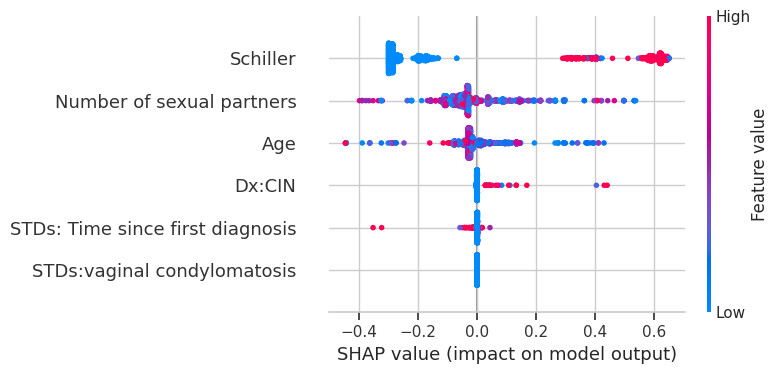

In [48]:
import shap
import matplotlib.pyplot as plt

# Create explainer using the model-agnostic SHAP Explainer
explainer = shap.Explainer(final_model.predict, X_final)
shap_values = explainer(X_final)

# Plot SHAP summary (dot plot)
plt.figure(figsize=(10, 6))
shap.plots.beeswarm(shap_values, show=False)
plt.tight_layout()
plt.show()

In [53]:
from sklearn.preprocessing import StandardScaler

# Fit scaler on training data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled[xgboost_features])

# Save the scaler for use in Streamlit
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']